# Comparing two groups the Bayesian way

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette("tab10")

# Statistical modelling
import pymc3 as pm
import theano 
import theano.tensor as tt
import patsy
import scipy.stats as st

print(f'{pm.__name__}: v. {pm.__version__}')
print(f'{theano.__name__}: v. {theano.__version__}')

pymc3: v. 3.5
theano: v. 1.0.2


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
SEED = 20180730

np.random.seed(SEED)

## Generate data

In [4]:
mu_real = np.array([90, 100])
sd_real = np.array([10, 3])

n_samples = np.array([100, 100])
factor_levels = np.array(['Manual', 'ACC'])

In [5]:
data = pd.DataFrame(data={
    'y':np.concatenate(
        [np.random.normal(loc=mu_real[i], scale=sd_real[i], size=n_samples[i]) for i, _ in enumerate(factor_levels)]
    ), 
    'x':np.repeat(factor_levels, n_samples)
                          })
         
data.x = pd.Categorical(data.x, categories=['Manual', 'ACC'], ordered=False)
data.head()

,y,x
0,79.713492,Manual
1,102.658322,Manual
2,101.141693,Manual
3,90.644940,Manual
4,104.814662,Manual


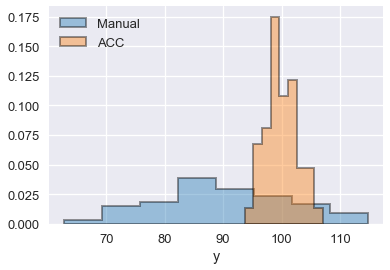

In [6]:
for cat in data.x.cat.categories:
    sns.distplot(data[data.x==cat].y, norm_hist=True, kde=False, label=cat, hist_kws={'histtype':'stepfilled', 'edgecolor':'k', 'lw':2})

plt.legend();

In [7]:
data.groupby('x').agg(['mean', 'std'])

y           
             mean        std
x                           
Manual  89.995199  11.094731
ACC     99.983327   2.703807

## Bayesian modelling

In [8]:
BURNIN=1000
TUNE=1000
SAMPLES=1000

In [9]:
with pm.Model() as model:
    
    # Prior on 'mu'
    mu = pm.Normal('mu', mu=data.y.mean(), sd=50, shape=2)
    
    # Prior on 'sd'
    sd = pm.HalfNormal('sd', sd=50, shape=2)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu[data.x.cat.codes.values], sd=sd[data.x.cat.codes.values], observed=data.y)
    
    delta_mu = pm.Deterministic('delta_mu', mu[1]-mu[0])
    delta_sd = pm.Deterministic('delta_sd', sd[1]-sd[0])
    
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED)

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|█████████████| 12000/12000 [00:10<00:00, 1199.25draws/s]


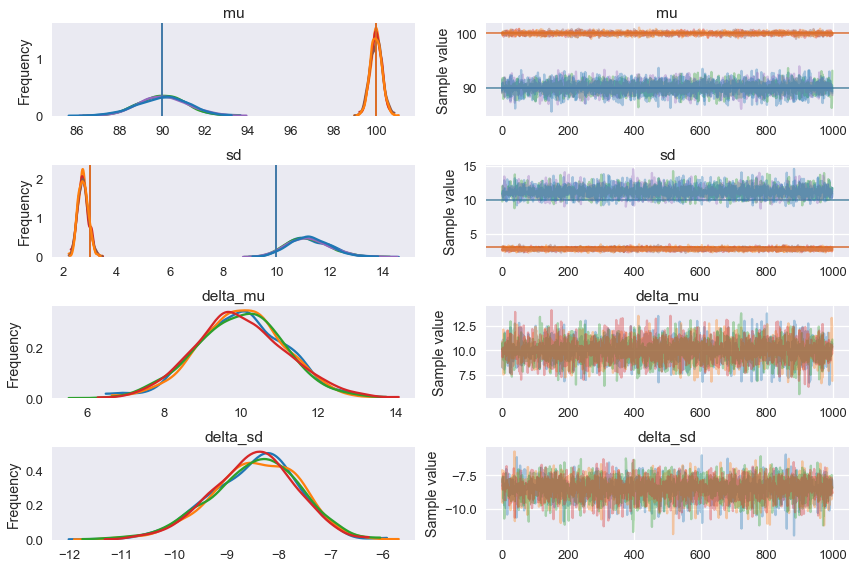

In [10]:
pm.traceplot(trace, lines={'mu':mu_real, 'sd':sd_real});

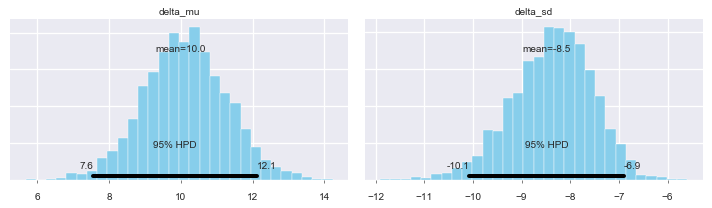

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
pm.plot_posterior(trace, varnames=['delta_mu', 'delta_sd'], round_to=1, ax=ax);

In [12]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,90.00,1.13,0.01,87.61,92.06,6632.06,1.0
mu__1,99.98,0.27,0.00,99.47,100.55,5430.13,1.0
sd__0,11.22,0.81,0.01,9.75,12.82,5639.57,1.0
sd__1,2.74,0.19,0.00,2.37,3.11,4622.82,1.0
delta_mu,9.99,1.16,0.02,7.56,12.13,6526.43,1.0
delta_sd,-8.48,0.83,0.01,-10.08,-6.90,5621.86,1.0


## Posterior predictive check

In [13]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head()

,mu__0,mu__1,sd__0,sd__1,delta_mu,delta_sd
0,89.271739,99.948902,10.977735,2.704980,10.677163,-8.272755
1,91.516614,99.730804,10.770386,2.461525,8.214191,-8.308861
2,89.189450,100.266821,10.444457,2.808255,11.077371,-7.636202
3,91.149539,99.740660,12.067757,2.598889,8.591121,-9.468868
4,89.308529,100.034402,10.654259,2.573488,10.725873,-8.080772


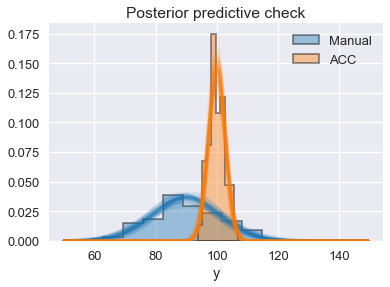

In [14]:
fig, ax = plt.subplots()

THIN = 100
X = np.arange(50, 150, 0.5)

for i, group in enumerate(data.x.cat.categories): 
    sns.distplot(data[data.x==group].y, kde=False, norm_hist=True, label=group, ax=ax, hist_kws={'histtype':'stepfilled', 'edgecolor':'k', 'lw':2})

    for mu, sd in zip(trace_df[f'mu__{i}'][::THIN], trace_df[f'sd__{i}'][::THIN]):
        ax.plot(X, st.norm.pdf(x=X, loc=mu, scale=sd), alpha=0.1, color=sns.color_palette()[i])

plt.title('Posterior predictive check')
plt.legend();

## Paired t-test

In [15]:
n_drivers = 5
n_sample = 200
n = n_drivers * n_sample

labels_block = ['Driver_{}'.format(i+1) for i in range(n_drivers)]

block = np.repeat(labels_block, repeats=n_sample)

In [16]:
block.shape

(1000,)

In [17]:
labels_block

['Driver_1', 'Driver_2', 'Driver_3', 'Driver_4', 'Driver_5']

In [18]:
x = np.tile(np.array([0, 1]), n_drivers*n_sample//2)
x.shape

(1000,)

In [19]:
Xmat_intercept_slope = patsy.dmatrix('0 + block + block:x - x', data={'block':block, 'x':x}, return_type='dataframe')
Xmat_intercept_slope.shape

(1000, 10)

In [20]:
intercept_mean = 100
intercept_sd = 0.5

slope_mean = 5
slope_sd = 4.5

intercept_effect = np.random.normal(loc=intercept_mean, scale=intercept_sd, size=n_drivers)
slope_effect =  np.random.normal(loc=slope_mean, scale=slope_sd, size=n_drivers)

all_effects = np.concatenate((intercept_effect, slope_effect), axis=0)
all_effects

array([ 99.96388155,  99.08517647,  99.91010186, 100.86054502,
        99.9225202 ,   7.59666168,   5.93442286,   3.73232691,
         6.91308439,   3.86046414])

In [21]:
lin_pred_intercept_slope = np.dot(Xmat_intercept_slope, all_effects)


In [22]:
eps = np.random.normal(loc=0, scale=2, size=n)

In [23]:
err_intercept_effect = np.random.uniform(low=0, high=0, size=n_drivers)
err_slope_effect =  np.random.uniform(low=1, high=1.3, size=n_drivers)

err_all_effects = np.concatenate((err_intercept_effect, err_slope_effect), axis=0)
err_all_effects

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.0269433 , 1.19291791, 1.04019422, 1.07672116, 1.21535587])

In [24]:
err_lin_pred_intercept_slope = np.dot(Xmat_intercept_slope, err_all_effects)
err_lin_pred_intercept_slope[:10]

array([0.       , 1.0269433, 0.       , 1.0269433, 0.       , 1.0269433,
       0.       , 1.0269433, 0.       , 1.0269433])

In [25]:
y_intercept_slope = lin_pred_intercept_slope + eps + eps*err_lin_pred_intercept_slope
data_hier_intercept_slope = pd.DataFrame({'y':y_intercept_slope, 'x':x, 'block':block})

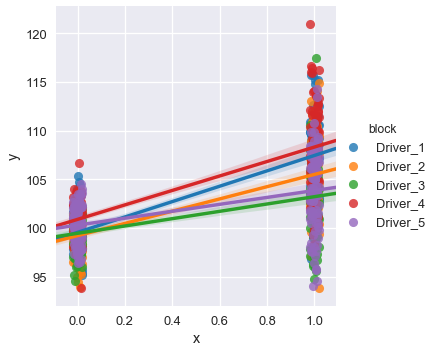

In [26]:
sns.lmplot(x='x', y='y', hue='block', data=data_hier_intercept_slope, x_jitter=0.02)

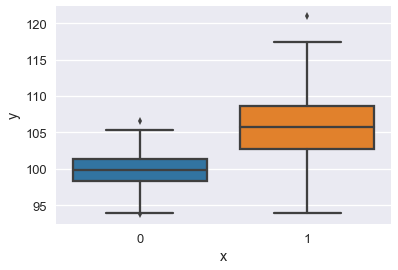

In [27]:
sns.boxplot(x='x', y='y', data=data_hier_intercept_slope)

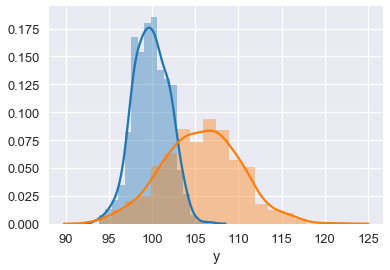

In [28]:
sns.distplot(data_hier_intercept_slope.y[data_hier_intercept_slope.x == 0])
sns.distplot(data_hier_intercept_slope.y[data_hier_intercept_slope.x == 1])